In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32


In [2]:
fName = "../data/20190103-22-53-substorms.csv"

In [3]:
smssDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smssDF.columns = [ "datetime", "mlat", "mlt" ]
# convert to hour
smssDF['hour'] = pandas.DatetimeIndex(smssDF['datetime']).hour
smssDF.head()

,datetime,mlat,mlt,hour
0,1996-01-01 20:16:00,71.32,22.45,20
1,1996-01-01 23:36:00,70.23,0.07,23
2,1996-01-02 00:25:00,69.36,22.92,0
3,1996-01-02 14:12:00,70.06,23.20,14
4,1996-01-02 16:09:00,65.81,0.62,16


In [4]:
hrDF = smssDF.groupby(["hour"]).size()

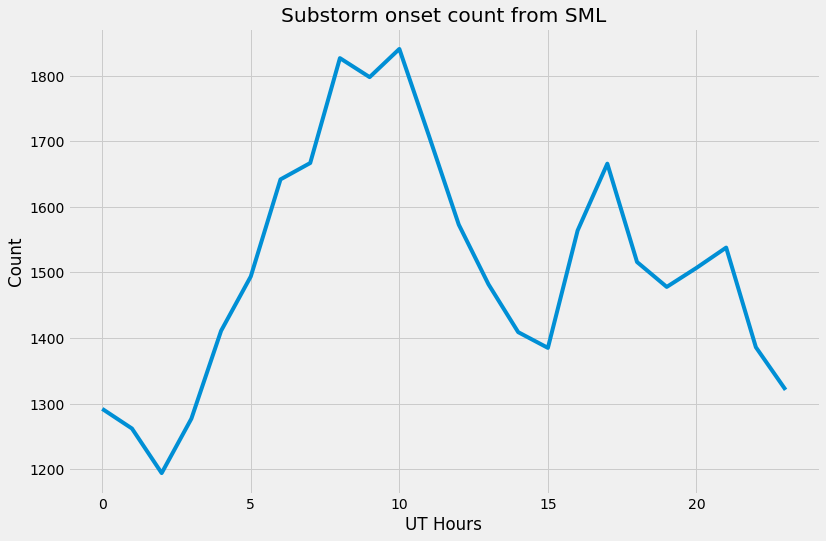

In [5]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrDF.index.values, hrDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
ax.set_title("Substorm onset count from SML")
fig.savefig("../plots/hours_count_sml_onset.png")

In [6]:
colNames = ["date"]
nBins = 1
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
colNames += [ "label", "pred_label" ]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]

In [7]:
predDF = pandas.read_csv("../data/all_data_pred_ut_corr.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF['hour'] = pandas.DatetimeIndex(predDF['date']).hour

In [8]:
onsetDF = predDF[ predDF["pred_label"] == 1 ]
noOnsetDF = predDF[ predDF["pred_label"] == 0 ]
predDF.head()

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,hour
0,1997-01-01 00:00:00,0,0,0,0.938758,0.061242,0
1,1997-01-01 01:50:00,1,1,0,0.949338,0.050662,1
2,1997-01-01 01:55:00,1,1,0,0.948706,0.051294,1
3,1997-01-01 02:00:00,1,1,0,0.947950,0.052050,2
4,1997-01-01 02:05:00,1,1,0,0.947025,0.052975,2


In [9]:
hrOnsetDF = onsetDF.groupby(["hour"]).size()
hrnOnsetDF = noOnsetDF.groupby(["hour"]).size()
allHrDF = predDF.groupby(["hour"]).size()

In [10]:
print hrOnsetDF.index.values
print hrOnsetDF.values

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 7570  7413  7251  7957  8418  8942  9775 10443 11212 11133 10723  9981
  9494  9034  8248  8393  9397  9437  8909  8956  8787  8722  8227  7656]


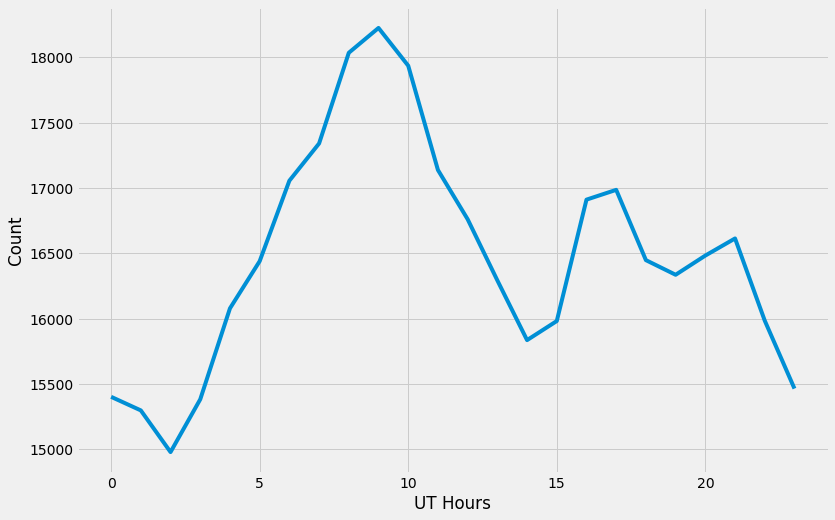

In [11]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(allHrDF.index.values.astype(float), allHrDF.values.astype(float))
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
# ax.set_ylim([12000,14000])
fig.savefig("../plots/hours_count_pred_all.png")

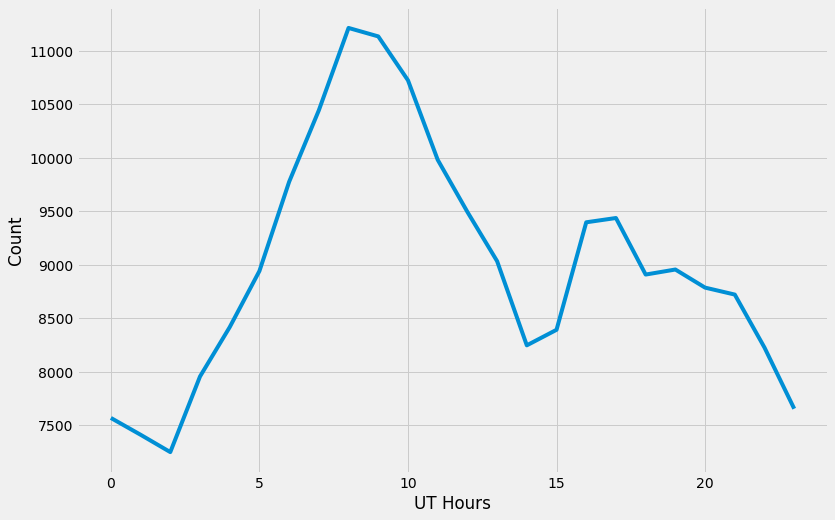

In [12]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrOnsetDF.index.values, hrOnsetDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
fig.savefig("../plots/hours_count_pred_onset.png")

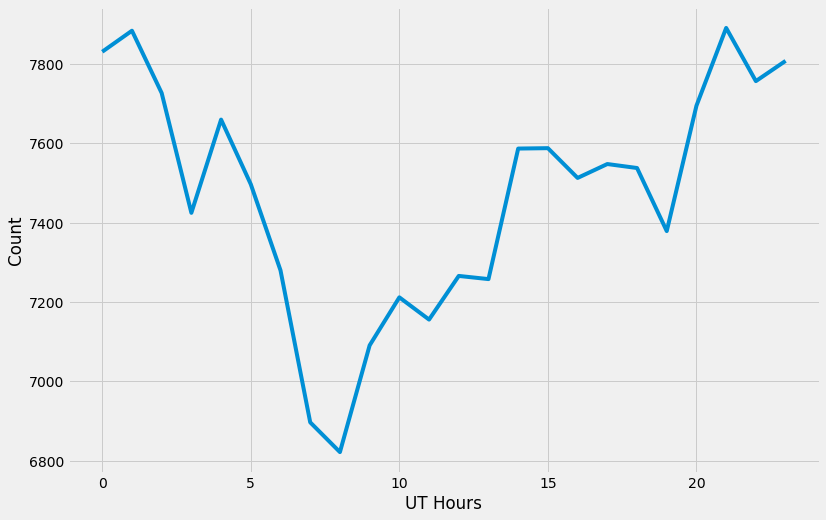

In [13]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hrnOnsetDF.index.values, hrnOnsetDF.values)
ax.set_xlabel("UT Hours")
ax.set_ylabel("Count")
fig.savefig("../plots/nonset.png")

In [14]:
predDF.head()

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,hour
0,1997-01-01 00:00:00,0,0,0,0.938758,0.061242,0
1,1997-01-01 01:50:00,1,1,0,0.949338,0.050662,1
2,1997-01-01 01:55:00,1,1,0,0.948706,0.051294,1
3,1997-01-01 02:00:00,1,1,0,0.947950,0.052050,2
4,1997-01-01 02:05:00,1,1,0,0.947025,0.052975,2


In [15]:
uniqHours = numpy.sort(predDF["hour"].unique())
prDict = {}
# prDict["hour"] = []
prDict["prn1"] = []
prDict["rec1"] = []
prDict["prn0"] = []
prDict["rec0"] = []
prDict["cnt01"] = []
prDict["pred_cnt01"] = []
for _uqh in uniqHours:
#     prDict["hour"].append(_uqh)
    _selDF = predDF[predDF["hour"] == _uqh]
    # filter true positives and other parameters for 1's
    _tp1 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 1) ].shape[0])
    _fp1 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 0) ].shape[0])
    _fn1 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 1) ].shape[0])
    _pred_cnt1 = round(\
            float(_selDF[ (_selDF["pred_label"] == 1) ].shape[0]))
    _cnt1 = round(\
            float(_selDF[ (_selDF["label"] == 1) ].shape[0]))
    # and get precision and recall for 1's
    prDict["prn1"].append(round(_tp1/(_tp1+_fp1),2))
    prDict["rec1"].append(round(_tp1/(_tp1+_fn1),2))
    # similar calculations for 0's
    _tp0 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 0) ].shape[0])
    _fp0 = float(_selDF[ (_selDF["pred_label"] == 0) &\
                 (_selDF["label"] == 1) ].shape[0])
    _fn0 = float(_selDF[ (_selDF["pred_label"] == 1) &\
                 (_selDF["label"] == 0) ].shape[0])
    _pred_cnt0 = round(\
            float(_selDF[ (_selDF["pred_label"] == 0) ].shape[0]))
    _cnt0 = round(\
            float(_selDF[ (_selDF["label"] == 0) ].shape[0]))
    prDict["cnt01"].append( round((_cnt0/_cnt1),2) )
    prDict["pred_cnt01"].append( round((_pred_cnt0/_pred_cnt1),2) )
    prDict["prn0"].append(round(_tp0/(_tp0+_fp0),2))
    prDict["rec0"].append(round(_tp0/(_tp0+_fn0),2))

# convert to a DF
prDF = pandas.DataFrame(prDict, index=uniqHours)
prDF

,cnt01,pred_cnt01,prn0,prn1,rec0,rec1
0,1.21,1.03,0.81,0.72,0.75,0.79
1,1.25,1.06,0.81,0.71,0.75,0.78
2,1.27,1.07,0.82,0.72,0.76,0.79
3,1.18,0.93,0.82,0.72,0.73,0.81
4,1.06,0.91,0.80,0.74,0.74,0.80
5,1.01,0.84,0.79,0.74,0.72,0.81
6,0.91,0.74,0.78,0.75,0.70,0.82
7,0.88,0.66,0.80,0.75,0.68,0.85
8,0.81,0.61,0.79,0.76,0.67,0.86
9,0.83,0.64,0.77,0.75,0.66,0.84


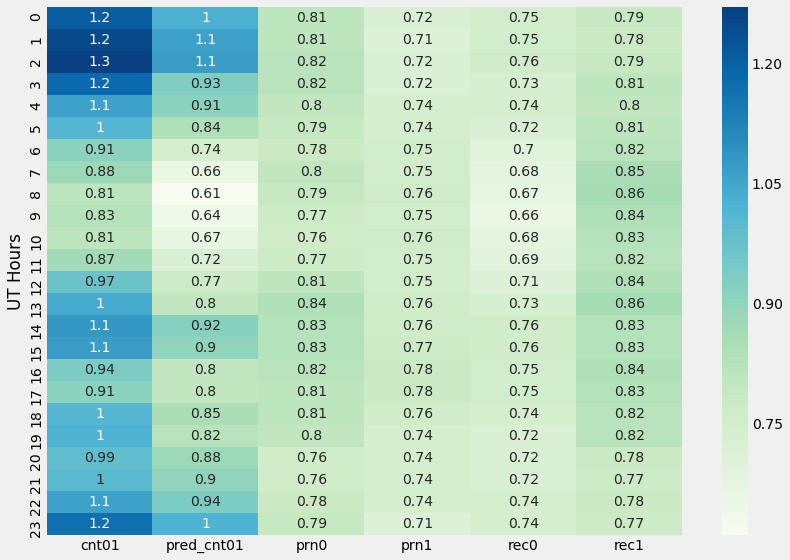

In [16]:
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(nrows=1, ncols=1,\
                    figsize=(12,8), sharex=True)
sns.heatmap(prDF, annot=True, cmap="GnBu", ax=axes) 
axes.set_ylabel("UT Hours")
fig.tight_layout()
fig.savefig("../plots/UT_prn_rec.png")